In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm

In [2]:
# clean data
data = pd.read_csv('data.csv')
data.head()

,Dates,SPX,VIX,C2800,C2900,C3000,C3100,C3200,P2800,P2900,P3000,P3100,P3200,LIBOR,SOFR,SPX_VOL30,SPX_VOL360
0,2018/4/2,2581.88,23.62,140.0,114.0,71.5,47.0,42.0,297.0,325.8,408.45,473.2,447.0,2.31175,1.80,20.21,10.77
1,2018/4/3,2614.45,21.10,140.0,114.0,77.5,47.0,42.0,297.0,325.8,408.45,473.2,447.0,2.32084,1.83,20.62,10.81
2,2018/4/4,2644.69,20.06,140.0,127.0,77.5,50.0,42.0,297.0,325.8,408.45,473.2,447.0,2.32461,1.74,20.93,10.85
3,2018/4/5,2662.84,18.94,140.0,127.0,77.5,50.0,43.0,297.0,325.8,408.45,473.2,447.0,2.33063,1.75,21.05,10.86
4,2018/4/6,2604.47,21.49,140.0,127.0,77.5,50.0,32.0,297.0,325.8,408.45,473.2,447.0,2.33746,1.75,21.37,11.03


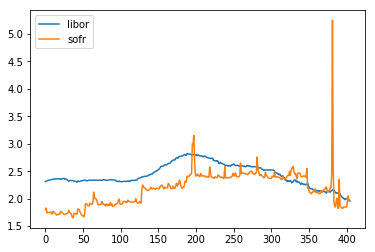

In [3]:
# using SPFR to replace LIBOR
# Why SOFR increased by 2.5% on Sept 17th?
plt.plot(data.LIBOR, label = 'libor')
plt.plot(data.SOFR, label = 'sofr')
plt.legend()
plt.show()

<img src="https://tva1.sinaimg.cn/large/006y8mN6gy1g85d5sj45xj30ti0fq75r.jpg" width = "45%" />

----
- BSM Formula

<img src="https://tva1.sinaimg.cn/large/006y8mN6gy1g85derir5uj30x20lggnb.jpg" width = "55%" />

In [4]:
# using BSM calculate price(theoretical) and vega
def BSM(s,k,t,r,sigma,cp):
    d1 = (log(s/k) + (r+0.5*sigma**2)*t) / (sigma*sqrt(t))
    d2 = d1 - sigma*sqrt(t)
    # BSM vega (1st patial derivative of BSM with the respect of sigma), using for Newton's method
    vega = s*sqrt(t) * norm.cdf(d1,0,1)
    # BSM price
    if cp == 'C': # Call
        call = s*norm.cdf(d1,0,1) - k*exp(-r*t) * norm.cdf(d2,0,1)
        return call, vega
    else: # Put
        put = k*exp(-r*t) * norm.cdf(-d2,0,1) - s*norm.cdf(-d1,0,1)
        return put, vega
    

# Newton's method: x_n+1 = x_n - f(x_n)/f'(x_n)
# calculate implied volatility
def IV(date, option):  # option means the name of the option, string
    t = (pd.to_datetime('2019/12/20') - pd.to_datetime(date)).days/365  # day to mature
    tem = data.loc[data.Dates == date]
    mkt_p = tem[option].values[0]  # market price
    k = float(option[1:])  # strike price
    cp = option[0] # call or put
    r = tem['SOFR'].values[0]/100  # SOFR
    s = tem['SPX'].values[0]  # underlying (SPX)
    sigma = 0.5  # initial sigma

    bsm_p, vega = BSM(s,k,t,r,sigma,cp)
    sigma_pre = sigma
    sigma = sigma_pre - (mkt_p - bsm_p)/(-1*vega)
    while abs(sigma - sigma_pre) > 0.001:  
        sigma_pre = sigma
        bsm_p, vega = BSM(s,k,t,r,sigma,cp)
        sigma = sigma_pre - (mkt_p - bsm_p)/(-1*vega)  # Newton's method
    return sigma

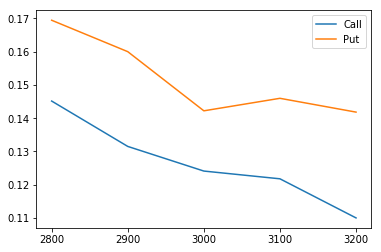

In [5]:
date = '2018/9/5'
clist = ['C2800','C2900','C3000','C3100','C3200']
plist = ['P2800','P2900','P3000','P3100','P3200']
result = pd.DataFrame(np.matrix([[0]*5]*2))
result.columns = ['2800','2900','3000','3100','3200']
tem = [0 for i in range(5)]

for i in range(5):
    tem[i] = IV(date,clist[i])
result.iloc[0,:] = tem
for i in range(5):
    tem[i] = IV(date,plist[i])
result.iloc[1,:] = tem
plt.plot(result.iloc[0,:], label = 'Call')
plt.plot(result.iloc[1,:], label = 'Put')
plt.legend()
plt.show()